# Predication of bladder cancer

# import libraries

In [66]:
import numpy as np 
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, f1_score, classification_report,
ConfusionMatrixDisplay, roc_curve, r2_score, auc, RocCurveDisplay, roc_curve, roc_auc_score) 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification 
import tensorflow as tf
from tensorflow import keras
import scikeras 
from scikeras.wrappers import KerasClassifier 
import os
import warnings
warnings.filterwarnings('ignore')


## Upload dataset

In [67]:
df = pd.read_csv('Lab_tests.csv' )
print("Original Data:\n", df.shape)
print("Original Data:\n", df.columns)
print("Original Data:\n", df.isnull().sum())
df.head(2)

Original Data:
 (1336, 39)
Original Data:
 Index(['Patient Number', 'Disease', 'Albumin', 'Alk', 'ALT (GPT)', 'AST (GOT)',
       'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Direct Bilirubin',
       'Estimated GFR', 'Glucose AC', 'Nitrite', 'Urine occult Blood', 'pH',
       'Potassium', 'Sodium', 'Specific Gravity', 'Strip WBC',
       'Total Bilirubin', 'Total Cholesterol', 'Total Protein', 'Triglyceride',
       'Urine epitheilum (UL)', 'Urine epithelium count', 'Uric acid',
       'Urine Bilirubin', 'Urine Glucose', 'Urine Ketone', 'Urine Protein',
       'Urobilinogen', 'age', 'gender', 'Hypertention', 'Diabetes', 'Smoking',
       'Drinking', 'FamilyHistory'],
      dtype='object')
Original Data:
 Patient Number              0
Disease                     0
Albumin                   300
Alk                       506
ALT (GPT)                  91
AST (GOT)                  62
BUN                        25
Calcium                   572
Chloride                  113
Creatinine     

,Patient Number,Disease,Albumin,Alk,ALT (GPT),AST (GOT),BUN,Calcium,Chloride,Creatinine,...,Urine Ketone,Urine Protein,Urobilinogen,age,gender,Hypertention,Diabetes,Smoking,Drinking,FamilyHistory
0,222159,Cystitis,3.9,53.0,28.0,25.0,11.0,NaN,107.0,0.6,...,NaN,0.0,0.2,72.0,0.0,0,0,0,0,0
1,397523,Cystitis,3.2,87.0,14.0,26.0,9.8,NaN,101.8,0.6,...,0.0,1.0,0.1,74.0,0.0,0,0,0,0,0


In [68]:
df.Disease.value_counts()

Disease
UrinaryBladder    591
Prostate          201
Kidney            200
Uterus            200
Cystitis          144
Name: count, dtype: int64

In [69]:
df.columns

Index(['Patient Number', 'Disease', 'Albumin', 'Alk', 'ALT (GPT)', 'AST (GOT)',
       'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Direct Bilirubin',
       'Estimated GFR', 'Glucose AC', 'Nitrite', 'Urine occult Blood', 'pH',
       'Potassium', 'Sodium', 'Specific Gravity', 'Strip WBC',
       'Total Bilirubin', 'Total Cholesterol', 'Total Protein', 'Triglyceride',
       'Urine epitheilum (UL)', 'Urine epithelium count', 'Uric acid',
       'Urine Bilirubin', 'Urine Glucose', 'Urine Ketone', 'Urine Protein',
       'Urobilinogen', 'age', 'gender', 'Hypertention', 'Diabetes', 'Smoking',
       'Drinking', 'FamilyHistory'],
      dtype='object')

## Select relevant disease groups:
Bladder cancer and cystitis were selected, since the comparison is clinically meaningful: both conditions have similar symptoms - hematuria (blood in urine) and dysuria (pain associated with urination) 

## Handling with missing values

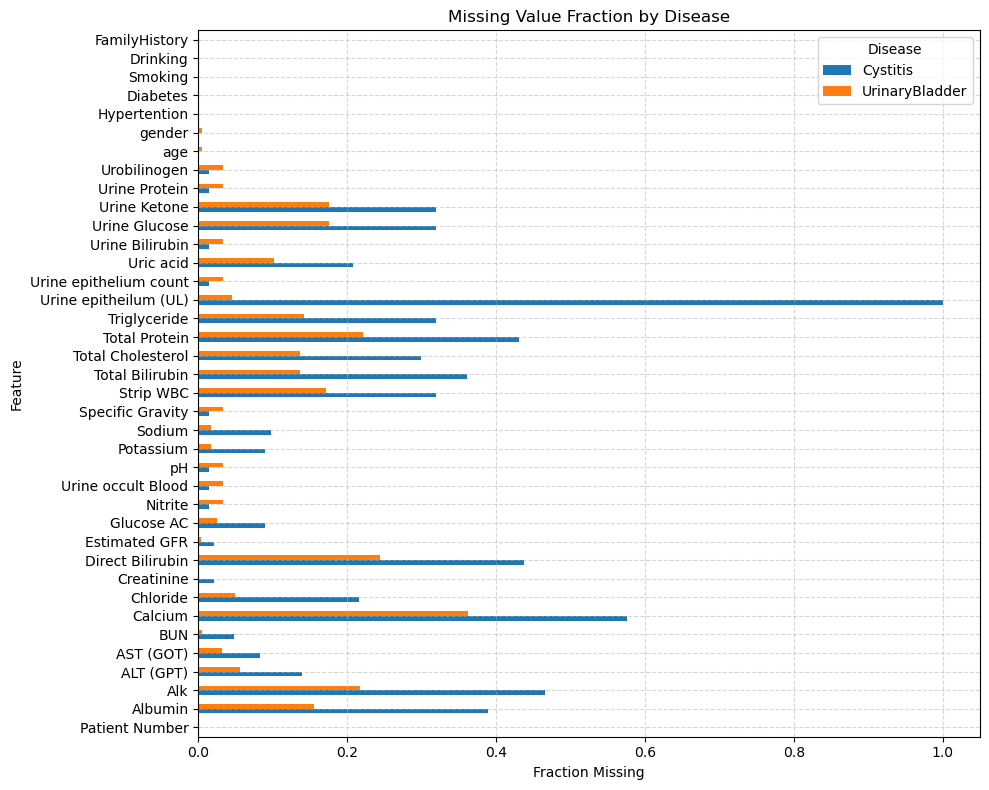

In [70]:
# Check if there are lab tests that are specifically missing in either one of the groups:
disease_groups = ['UrinaryBladder', 'Cystitis']
Bladder = df[df['Disease'].isin(disease_groups)]

# Get all feature columns except 'Disease'
feature_cols = [col for col in Bladder.columns if col != 'Disease']

# Calculate missing value fraction per column, per disease
missing_by_disease = (
    Bladder.groupby('Disease')[feature_cols]
    .apply(lambda x: x.isnull().mean())
    .T  # Transpose for better visualization
)

# Plot
missing_by_disease.plot(kind='barh', figsize=(10, 8), title='Missing Value Fraction by Disease')
plt.xlabel('Fraction Missing')
plt.ylabel('Feature')
plt.legend(title='Disease')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Remove tests which are barely performed for specific disease:
Visually, it looks likes that there are specific tests that are differentially missing - for instance - urine epithelium test. This makes since, as the morphological appearance of cells is a diagnostic test for blader cancer, but not for cystitis. To following code checks whether there are additional tests that behave similarly and remove them

In [71]:
threshold = 0.3
# Identify columns to drop (any column exceeding threshold in either group)
cols_to_drop = missing_by_disease[
    (missing_by_disease > threshold).any(axis=1)
].index.tolist()

# Drop columns from the original DataFrame
Bladder_reduced = Bladder.drop(columns=cols_to_drop)

# Print what was dropped
print(f"Dropped columns (>{threshold*100:.0f}% missing in at least one group):")
print(cols_to_drop)


Dropped columns (>30% missing in at least one group):
['Albumin', 'Alk', 'Calcium', 'Direct Bilirubin', 'Strip WBC', 'Total Bilirubin', 'Total Protein', 'Triglyceride', 'Urine epitheilum (UL)', 'Urine Glucose', 'Urine Ketone']


In [72]:
Bladder_reduced.isnull().sum()

Patient Number              0
Disease                     0
ALT (GPT)                  53
AST (GOT)                  31
BUN                        10
Chloride                   60
Creatinine                  3
Estimated GFR               5
Glucose AC                 28
Nitrite                    22
Urine occult Blood         22
pH                         22
Potassium                  23
Sodium                     24
Specific Gravity           22
Total Cholesterol         124
Urine epithelium count     22
Uric acid                  90
Urine Bilirubin            22
Urine Protein              22
Urobilinogen               22
age                         3
gender                      3
Hypertention                0
Diabetes                    0
Smoking                     0
Drinking                    0
FamilyHistory               0
dtype: int64

In [73]:
Bladder_reduced.describe()

,Patient Number,ALT (GPT),AST (GOT),BUN,Chloride,Creatinine,Estimated GFR,Glucose AC,Nitrite,Urine occult Blood,...,Urine Bilirubin,Urine Protein,Urobilinogen,age,gender,Hypertention,Diabetes,Smoking,Drinking,FamilyHistory
count,7.350000e+02,682.000000,704.000000,725.000000,675.000000,732.000000,730.000000,707.000000,713.000000,713.000000,...,713.000000,713.000000,713.000000,732.000000,732.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,2.663747e+07,27.932551,38.339489,24.558759,104.780296,1.939877,66.302877,124.052334,0.161290,1.429173,...,0.103787,0.904628,0.338990,65.433060,0.647541,0.281633,0.153741,0.212245,0.191837,0.017687
std,1.600701e+07,34.092534,265.062788,25.300796,4.481036,2.662409,34.123544,87.103607,0.368057,1.289637,...,0.431094,1.069899,0.410973,10.296276,0.478063,0.450101,0.360946,0.409176,0.394013,0.131901
min,2.009660e+05,4.000000,5.000000,2.000000,85.000000,0.300000,2.600000,51.000000,0.000000,0.000000,...,0.000000,0.000000,0.100000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.198893e+07,15.000000,19.000000,12.000000,102.600000,0.800000,44.200000,97.000000,0.000000,0.000000,...,0.000000,0.000000,0.100000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.694497e+07,21.000000,23.000000,16.000000,105.000000,1.000000,70.800000,109.000000,0.000000,1.000000,...,0.000000,0.500000,0.200000,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.043944e+07,29.750000,29.000000,25.000000,108.000000,1.500000,87.600000,133.500000,0.000000,3.000000,...,0.000000,2.000000,0.200000,73.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5.394597e+07,561.000000,7024.000000,285.000000,126.000000,18.800000,181.500000,2138.000000,1.000000,3.000000,...,3.000000,3.000000,4.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
# Imputing with sklearn 
quantitative_tests=['ALT (GPT)','AST (GOT)','BUN','Chloride','Creatinine','Estimated GFR','Glucose AC','pH', 'Potassium', 'Sodium', 'Specific Gravity',
       'Total Cholesterol','Urine epithelium count','Uric acid','age']
categorical_tests=['Nitrite', 'Urine occult Blood', 'Urine Bilirubin','Urine Protein','Urobilinogen','gender']

# Separate the columns
quantitative_cols = [col for col in quantitative_tests if col in Bladder_reduced.columns]
categorical_cols = [col for col in categorical_tests if col in Bladder_reduced.columns]

# Create imputers
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mean imputer to quantitative tests
Bladder_reduced[quantitative_cols] = mean_imputer.fit_transform(Bladder_reduced[quantitative_cols])
# Apply mode imputer to categorical tests
Bladder_reduced[categorical_cols] = mode_imputer.fit_transform(Bladder_reduced[categorical_cols])
Bladder_reduced.describe()

,Patient Number,ALT (GPT),AST (GOT),BUN,Chloride,Creatinine,Estimated GFR,Glucose AC,Nitrite,Urine occult Blood,...,Urine Bilirubin,Urine Protein,Urobilinogen,age,gender,Hypertention,Diabetes,Smoking,Drinking,FamilyHistory
count,7.350000e+02,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,...,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,2.663747e+07,27.932551,38.339489,24.558759,104.780296,1.939877,66.302877,124.052334,0.156463,1.476190,...,0.100680,0.877551,0.334830,65.433060,0.648980,0.281633,0.153741,0.212245,0.191837,0.017687
std,1.600701e+07,32.838613,259.405030,25.127856,4.293983,2.656963,34.007121,85.426076,0.363541,1.298098,...,0.424953,1.064973,0.405461,10.275213,0.477614,0.450101,0.360946,0.409176,0.394013,0.131901
min,2.009660e+05,4.000000,5.000000,2.000000,85.000000,0.300000,2.600000,51.000000,0.000000,0.000000,...,0.000000,0.000000,0.100000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.198893e+07,16.000000,19.000000,12.000000,103.000000,0.800000,44.250000,98.000000,0.000000,0.000000,...,0.000000,0.000000,0.100000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.694497e+07,22.000000,23.000000,16.000000,105.000000,1.000000,70.700000,110.000000,0.000000,1.000000,...,0.000000,0.500000,0.200000,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.043944e+07,29.000000,30.500000,24.629379,107.000000,1.500000,87.600000,132.000000,0.000000,3.000000,...,0.000000,2.000000,0.200000,73.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5.394597e+07,561.000000,7024.000000,285.000000,126.000000,18.800000,181.500000,2138.000000,1.000000,3.000000,...,3.000000,3.000000,4.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
Bladder_reduced.isnull().sum()

Patient Number            0
Disease                   0
ALT (GPT)                 0
AST (GOT)                 0
BUN                       0
Chloride                  0
Creatinine                0
Estimated GFR             0
Glucose AC                0
Nitrite                   0
Urine occult Blood        0
pH                        0
Potassium                 0
Sodium                    0
Specific Gravity          0
Total Cholesterol         0
Urine epithelium count    0
Uric acid                 0
Urine Bilirubin           0
Urine Protein             0
Urobilinogen              0
age                       0
gender                    0
Hypertention              0
Diabetes                  0
Smoking                   0
Drinking                  0
FamilyHistory             0
dtype: int64

## Handling Outliers
This will be done by taking into account which of the outliers may have a clinical meaning (an out-of-range value that is indicative of a disease), or looks like a data-entry or measuring error.  

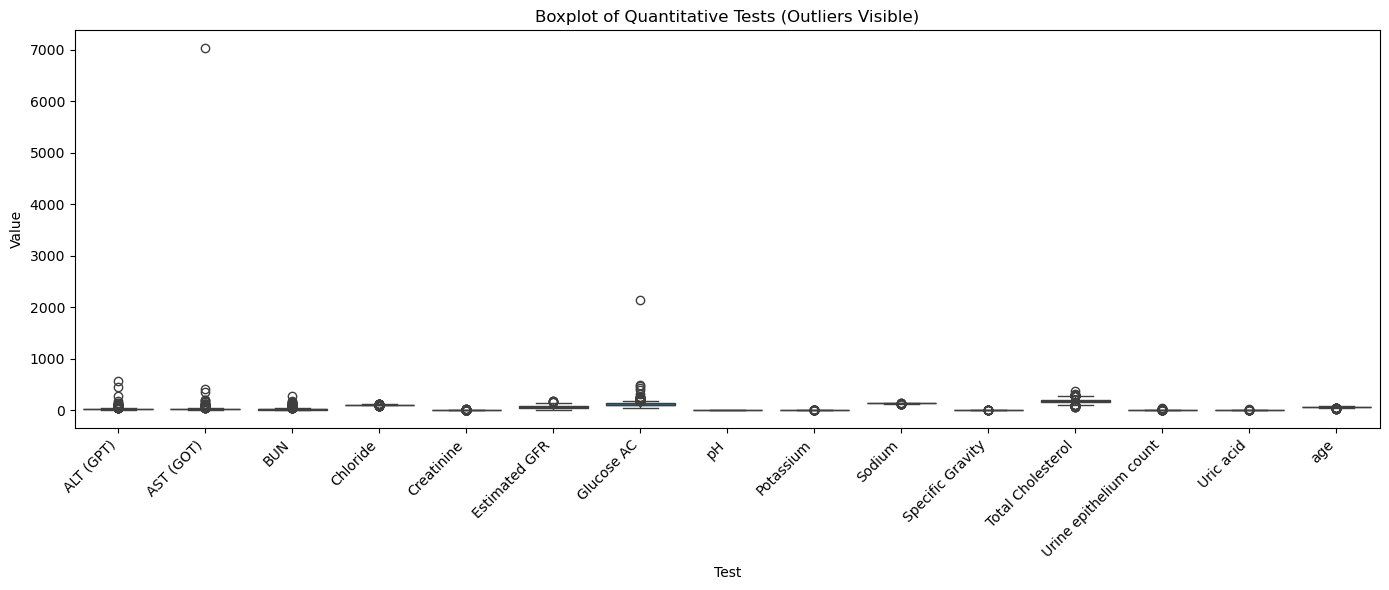

In [76]:
# define quantitative tests:
quantitative_tests=['ALT (GPT)','AST (GOT)','BUN','Chloride','Creatinine','Estimated GFR','Glucose AC','pH', 'Potassium', 'Sodium', 'Specific Gravity',
       'Total Cholesterol','Urine epithelium count','Uric acid','age']
# Ensure columns exist in the DataFrame
quant_cols = [col for col in quantitative_tests if col in Bladder_reduced.columns]

# Identify outliers using IQR method
def find_outliers_iqr(Bladder_reduced, columns):
    outlier_Bladder_reduced = pd.DataFrame(index=Bladder_reduced.index)
    
    for col in columns:
        Q1 = Bladder_reduced[col].quantile(0.10)
        Q3 = Bladder_reduced[col].quantile(0.90)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (Bladder_reduced[col] < lower) | (Bladder_reduced[col] > upper)
        outlier_Bladder_reduced[col] = outlier_mask
    
    return outlier_Bladder_reduced

# Get DataFrame of boolean values: True = outlier
outliers = find_outliers_iqr(Bladder_reduced, quant_cols)

# Show rows that have at least one outlier
rows_with_outliers = Bladder_reduced[outliers.any(axis=1)]
# Melt the dataframe for easier plotting
melted = Bladder_reduced[quant_cols].melt(var_name="Test", value_name="Value")

plt.figure(figsize=(14, 6))
sns.boxplot(x="Test", y="Value", data=melted)
plt.xticks(rotation=45, ha='right')
plt.title("Boxplot of Quantitative Tests (Outliers Visible)")
plt.tight_layout()
plt.show()

### Dealing with tests that are shown to have outliers: 

In [77]:
Bladder_reduced['ALT (GPT)'].describe()

count    735.000000
mean      27.932551
std       32.838613
min        4.000000
25%       16.000000
50%       22.000000
75%       29.000000
max      561.000000
Name: ALT (GPT), dtype: float64

In [78]:
## for ALT (GPT) - no outliers removal is required, as high values (up to 2000 u/Li) are clinically meaningfull

In [79]:
Bladder_reduced['AST (GOT)'].describe()

count     735.000000
mean       38.339489
std       259.405030
min         5.000000
25%        19.000000
50%        23.000000
75%        30.500000
max      7024.000000
Name: AST (GOT), dtype: float64

In [80]:
## for AST (GOT) - outliers removal is required, as values > 1000 are interprated as extreme high values

In [81]:
# capping to remove the upper outliers:
# Calculate the 99.5th percentile value
cap_value = Bladder_reduced['AST (GOT)'].quantile(0.995)

# Cap values above the 99.5th percentile
Bladder_reduced['AST_(GOT)_capped'] = Bladder_reduced['AST (GOT)'].clip(upper=cap_value)
Bladder_reduced['AST_(GOT)_capped'].describe()

count    735.000000
mean      28.516087
std       21.712692
min        5.000000
25%       19.000000
50%       23.000000
75%       30.500000
max      196.950000
Name: AST_(GOT)_capped, dtype: float64

In [82]:
Bladder_reduced['BUN'].describe()

count    735.000000
mean      24.558759
std       25.127856
min        2.000000
25%       12.000000
50%       16.000000
75%       24.629379
max      285.000000
Name: BUN, dtype: float64

In [83]:
## for BUN - outliers removal is required, as values > 100 are interprated as extreme high values

In [84]:
#capping to remove the upper outliers:
# Calculate the 99.5th percentile value
cap_value = Bladder_reduced['BUN'].quantile(0.995)

# Cap values above the 99.5th percentile
Bladder_reduced['BUN_capped'] = Bladder_reduced['BUN'].clip(upper=cap_value)
Bladder_reduced['BUN_capped'].describe()

count    735.000000
mean      24.305915
std       23.258918
min        2.000000
25%       12.000000
50%       16.000000
75%       24.629379
max      152.290000
Name: BUN_capped, dtype: float64

In [85]:
Bladder_reduced['Glucose AC'].describe()

count     735.000000
mean      124.052334
std        85.426076
min        51.000000
25%        98.000000
50%       110.000000
75%       132.000000
max      2138.000000
Name: Glucose AC, dtype: float64

In [86]:
## for Glucose AC - outliers removal is required, as all values > 250 are interprated as extreme hyperglycemia

In [87]:
# cap glucose value 
#capping to remove the upper outliers:
# Calculate the 99.5th percentile value
cap_value = Bladder_reduced['Glucose AC'].quantile(0.995)

# Cap values above the 99.5th percentile
Bladder_reduced['Glucose_AC_capped'] = Bladder_reduced['Glucose AC'].clip(upper=cap_value)
Bladder_reduced['Glucose_AC_capped'].describe()

count    735.000000
mean     121.487980
std       41.695975
min       51.000000
25%       98.000000
50%      110.000000
75%      132.000000
max      413.550000
Name: Glucose_AC_capped, dtype: float64

In [88]:
Bladder_reduced['Total Cholesterol'].describe()

count    735.000000
mean     184.819967
std       41.446104
min       60.000000
25%      163.000000
50%      184.819967
75%      206.000000
max      365.000000
Name: Total Cholesterol, dtype: float64

In [89]:
## for total cholesterol - no capping is required

In [90]:
# Dropping un-capped columns:
columns_to_drop=['BUN','Glucose AC','AST (GOT)'] 
Bladder_fin=Bladder_reduced.drop(columns=columns_to_drop)
Bladder_fin.shape

(735, 28)

### Correlation between numerical features

In [93]:
# Correlation for numerical features
Bladder_numerical = Bladder_reduced[['ALT (GPT)', 'Chloride', 'Creatinine', 'Estimated GFR', 'Nitrite',
       'Urine occult Blood', 'pH', 'Potassium', 'Sodium', 'Specific Gravity',
       'Total Cholesterol', 'Urine epithelium count', 'Uric acid',
       'Urine Bilirubin', 'Urine Protein', 'Urobilinogen', 'age', 'gender',
       'Hypertention', 'Diabetes', 'Smoking', 'Drinking', 
       'FamilyHistory', 'AST_(GOT)_capped', 'BUN_capped', 'Glucose_AC_capped']]
correlation_matrix_numerical = Bladder_numerical.corr()
correlation_matrix_numerical

,ALT (GPT),Chloride,Creatinine,Estimated GFR,Nitrite,Urine occult Blood,pH,Potassium,Sodium,Specific Gravity,...,age,gender,Hypertention,Diabetes,Smoking,Drinking,FamilyHistory,AST_(GOT)_capped,BUN_capped,Glucose_AC_capped
ALT (GPT),1.000000,0.029154,-0.045867,0.045403,-0.030788,-0.046880,-0.046680,-0.045525,-0.040039,0.043434,...,-0.067663,-0.027767,-0.028141,-0.013622,0.004162,-0.014400,-0.016730,0.379373,-0.020661,-0.016344
Chloride,0.029154,1.000000,-0.308500,0.193715,-0.011985,-0.043180,-0.141131,-0.137283,0.228415,-0.019226,...,0.009954,0.031815,-0.109938,-0.066448,0.037138,0.041099,0.021977,-0.023799,-0.231708,0.006829
Creatinine,-0.045867,-0.308500,1.000000,-0.592782,0.018962,0.192141,0.186009,0.209052,-0.089304,0.005699,...,0.045815,0.002822,0.121561,0.040862,-0.054301,-0.060909,0.029162,-0.008101,0.585462,0.028743
Estimated GFR,0.045403,0.193715,-0.592782,1.000000,-0.012125,-0.136821,-0.069546,-0.242195,0.109223,0.047770,...,-0.293913,0.003384,-0.257675,-0.168899,-0.029045,0.043222,0.020733,0.003139,-0.521487,-0.060754
Nitrite,-0.030788,-0.011985,0.018962,-0.012125,1.000000,0.114723,0.038037,-0.044767,-0.066179,0.102959,...,0.024666,-0.091275,0.030076,-0.048594,-0.003738,-0.057650,0.055858,0.008058,0.012063,-0.007996
Urine occult Blood,-0.046880,-0.043180,0.192141,-0.136821,0.114723,1.000000,0.103746,0.054335,-0.091992,0.035640,...,0.050410,-0.077225,-0.009494,0.020908,-0.032795,-0.090946,-0.057214,-0.004401,0.148974,0.030012
pH,-0.046680,-0.141131,0.186009,-0.069546,0.038037,0.103746,1.000000,-0.029275,-0.023833,-0.108863,...,-0.021965,-0.111749,-0.080485,-0.062191,0.014759,0.003862,-0.034776,-0.003313,0.074180,-0.039386
Potassium,-0.045525,-0.137283,0.209052,-0.242195,-0.044767,0.054335,-0.029275,1.000000,-0.110918,-0.009349,...,0.023320,0.012498,0.027193,0.071148,0.045276,-0.018886,-0.037066,0.029814,0.183470,0.024130
Sodium,-0.040039,0.228415,-0.089304,0.109223,-0.066179,-0.091992,-0.023833,-0.110918,1.000000,0.023688,...,-0.063490,0.008543,-0.054108,-0.155956,-0.024847,0.027532,-0.009051,-0.051993,-0.108521,-0.091451
Specific Gravity,0.043434,-0.019226,0.005699,0.047770,0.102959,0.035640,-0.108863,-0.009349,0.023688,1.000000,...,-0.051564,0.071796,0.024315,0.053438,0.059093,-0.015469,-0.010922,-0.014542,-0.080995,0.062980


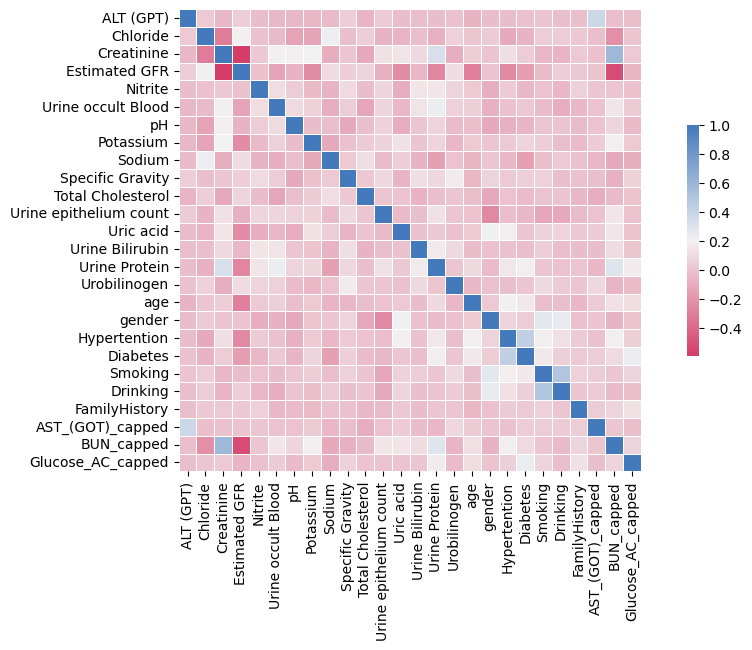

In [94]:
# Visualize the correlation for numerical features
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 6))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(0,250, as_cmap=True)
 
# Draw the heatmap
sns.heatmap(correlation_matrix_numerical, cmap=cmap, #vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});


#### Correlation analysis shows that "Estimated GFR" and "Createnin" tests are correlated, which makes since as both tests measures kidney function. It was decided however to leave both, as the relationship is not always straightforward. Same goes for "Estimated GFR" and BUN tests - both measures kidney function, but BUN test can also reflects changes in diet or hydration.  

## Feature Engineering - Data Transformation

In [95]:
Bladder_fin.columns

Index(['Patient Number', 'Disease', 'ALT (GPT)', 'Chloride', 'Creatinine',
       'Estimated GFR', 'Nitrite', 'Urine occult Blood', 'pH', 'Potassium',
       'Sodium', 'Specific Gravity', 'Total Cholesterol',
       'Urine epithelium count', 'Uric acid', 'Urine Bilirubin',
       'Urine Protein', 'Urobilinogen', 'age', 'gender', 'Hypertention',
       'Diabetes', 'Smoking', 'Drinking', 'FamilyHistory', 'AST_(GOT)_capped',
       'BUN_capped', 'Glucose_AC_capped'],
      dtype='object')

In [96]:
# Standardization
# Select relevant columns
columns_to_scale = ['ALT (GPT)','Chloride','Creatinine','Estimated GFR','pH', 'Potassium', 'Sodium', 'Specific Gravity',
       'Total Cholesterol','Urine epithelium count','Uric acid','age','AST_(GOT)_capped', 'BUN_capped', 'Glucose_AC_capped']
# Standardize
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(Bladder_clean),
                               columns=[col + '_std' for col in columns_to_scale],
                               index=Bladder_fin.index)  # Preserve index for proper concatenation

# Join with original dataframe
df1 = pd.concat([Bladder_fin, df_standardized], axis=1)

In [97]:
dfm=df1.drop(columns=columns_to_scale)
dfm.columns

Index(['Patient Number', 'Disease', 'Nitrite', 'Urine occult Blood',
       'Urine Bilirubin', 'Urine Protein', 'Urobilinogen', 'gender',
       'Hypertention', 'Diabetes', 'Smoking', 'Drinking', 'FamilyHistory',
       'ALT (GPT)_std', 'Chloride_std', 'Creatinine_std', 'Estimated GFR_std',
       'pH_std', 'Potassium_std', 'Sodium_std', 'Specific Gravity_std',
       'Total Cholesterol_std', 'Urine epithelium count_std', 'Uric acid_std',
       'age_std', 'AST_(GOT)_capped_std', 'BUN_capped_std',
       'Glucose_AC_capped_std'],
      dtype='object')

## Data Visualisation 


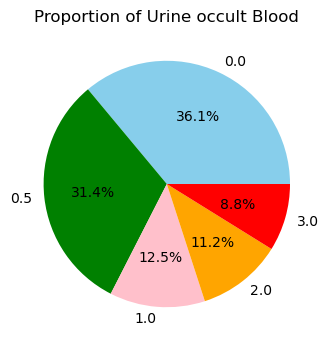

In [98]:
# Pie chart of heart disease presence
plt.figure(figsize=(4, 4))
dfm['Urine occult Blood'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue','green','pink','orange','red'], 
                                     labels=['0.0','0.5', '1.0', '2.0', '3.0'])
plt.title('Proportion of Urine occult Blood')
plt.ylabel('')
plt.show();

### Univariate analysis: Histogram


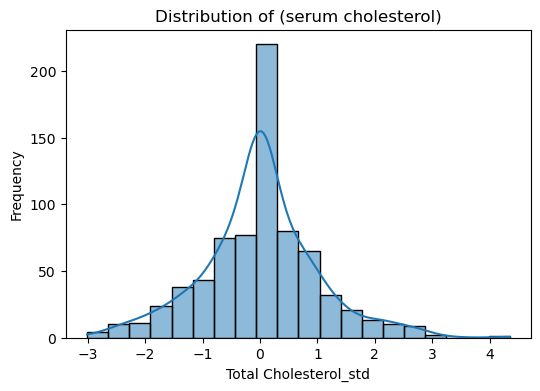

In [99]:
# Distribution of Total Cholesterol_std
plt.figure(figsize=(6, 4))
sns.histplot(dfm['Total Cholesterol_std'], bins=20, kde=True) 
plt.title('Distribution of (serum cholesterol)')
plt.xlabel('Total Cholesterol_std')
plt.ylabel('Frequency')
plt.show()

### Bivariate analysis: Bar charts

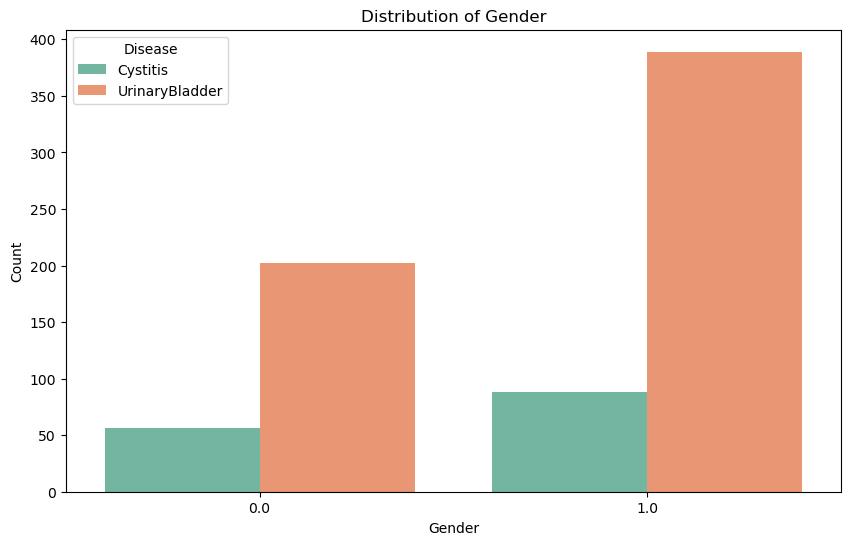

In [100]:
# Distribution of gender vs. disease type
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='Disease', data=dfm, palette='Set2')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

## Pre processing

In [101]:
columns_to_ignore=['Patient Number']
dfm=dfm.drop(columns=columns_to_ignore)
dfm.columns             

Index(['Disease', 'Nitrite', 'Urine occult Blood', 'Urine Bilirubin',
       'Urine Protein', 'Urobilinogen', 'gender', 'Hypertention', 'Diabetes',
       'Smoking', 'Drinking', 'FamilyHistory', 'ALT (GPT)_std', 'Chloride_std',
       'Creatinine_std', 'Estimated GFR_std', 'pH_std', 'Potassium_std',
       'Sodium_std', 'Specific Gravity_std', 'Total Cholesterol_std',
       'Urine epithelium count_std', 'Uric acid_std', 'age_std',
       'AST_(GOT)_capped_std', 'BUN_capped_std', 'Glucose_AC_capped_std'],
      dtype='object')

In [102]:
dfm['Disease'] = df1['Disease'] == 'UrinaryBladder'
print(dfm['Disease'].value_counts())
print(dfm['Disease'].isnull().sum())

Disease
True     591
False    144
Name: count, dtype: int64
0


In [103]:
X = dfm.drop('Disease', axis=1)#all features without the outcome
y = dfm['Disease']
print('X shape: ', X.shape)
print('y shape: ', y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
# Save column names before scaling
feature_names = X_train.columns
# Scale and convert back to DataFrame
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
# Scaling for the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X shape:  (735, 26)
y shape:  (735,)


### Decision trees

Accuracy: 70.588%
Precision: 80.460%
Recall: 81.871%


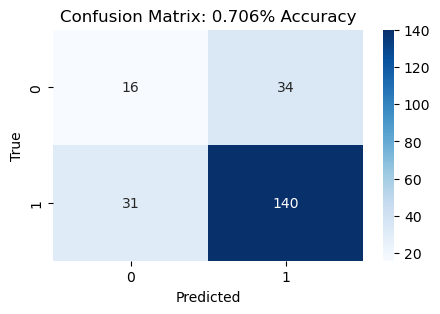

In [104]:
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

DT_y_preds = DT_model.predict(X_test)

DT_acc = accuracy_score(y_test, DT_y_preds)
DT_precision = precision_score(y_test, DT_y_preds ) 
DT_recall = recall_score(y_test, DT_y_preds )  

print(f"Accuracy: {DT_acc * 100:.3f}%")
print(f"Precision: {DT_precision * 100:.3f}%")
print(f"Recall: {DT_recall * 100:.3f}%")

DT_conf_mat = confusion_matrix(y_test, DT_y_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(DT_conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {DT_acc:.3f}% Accuracy')
plt.show()

In [105]:
#Hyperparameter tuning:
DT_grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'splitter': ['best', 'random'],  
    'min_samples_leaf': [1, 2, 3, 5, 7],
    'min_samples_split': [2, 3, 5, 7],  
    'max_features': ['sqrt', 'log2', None]  
}

# Perform GridSearchCV
DT_grid_search = GridSearchCV(DT_model, DT_grid_params, cv=5, n_jobs=-1, verbose=1)
DT_grid_search.fit(X_train, y_train)

# Get best parameters
DT_grid_search.best_params_


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'splitter': 'best'}

Accuracy: 78.281%
Precision: 78.873%
Recall: 98.246%


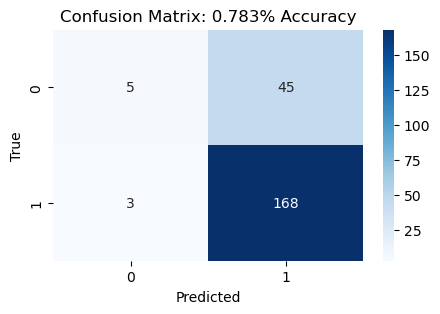

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 7,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'random'}

In [106]:
dt_best_model = DecisionTreeClassifier(criterion= 'gini',
 max_depth= 3,
 max_features= None,
 min_samples_leaf= 7,
 min_samples_split= 7,
 splitter= 'random')
dt_best_model.fit(X_train, y_train)

DT_y_preds = dt_best_model.predict(X_test)

DT_acc = accuracy_score(y_test, DT_y_preds)
DT_precision = precision_score(y_test, DT_y_preds ) 
DT_recall = recall_score(y_test, DT_y_preds )  

print(f"Accuracy: {DT_acc * 100:.3f}%")
print(f"Precision: {DT_precision * 100:.3f}%")
print(f"Recall: {DT_recall * 100:.3f}%")

DT_conf_mat = confusion_matrix(y_test, DT_y_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(DT_conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {DT_acc:.3f}% Accuracy')
plt.show()

# Display the hyperparameters of the model
dt_best_model.get_params()

### Random forest

Accuracy: 78.733%
Precision: 79.245%
Recall: 98.246%


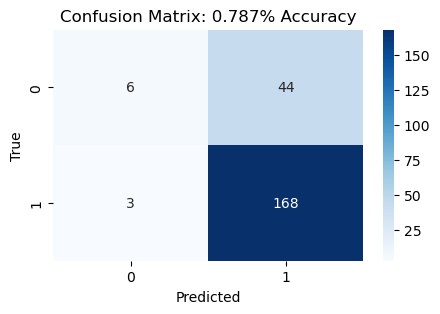

In [107]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

rf_y_preds = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_y_preds)
rf_precision = precision_score(y_test, rf_y_preds ) 
rf_recall = recall_score(y_test, rf_y_preds )  

print(f"Accuracy: {rf_acc * 100:.3f}%")
print(f"Precision: {rf_precision * 100:.3f}%")
print(f"Recall: {rf_recall * 100:.3f}%")

rf_conf_mat = confusion_matrix(y_test, rf_y_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(rf_conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {rf_acc:.3f}% Accuracy')
plt.show()

In [108]:
#Hyperparameter tuning:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("✅ Best params:", grid_search.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
✅ Best params: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [109]:
# Predict
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Confusion matrix
print(f"Accuracy: {rf_acc * 100:.3f}%")
print(f"Precision: {rf_precision * 100:.3f}%")
print(f"Recall: {rf_recall * 100:.3f}%")


Accuracy: 78.733%
Precision: 79.245%
Recall: 98.246%


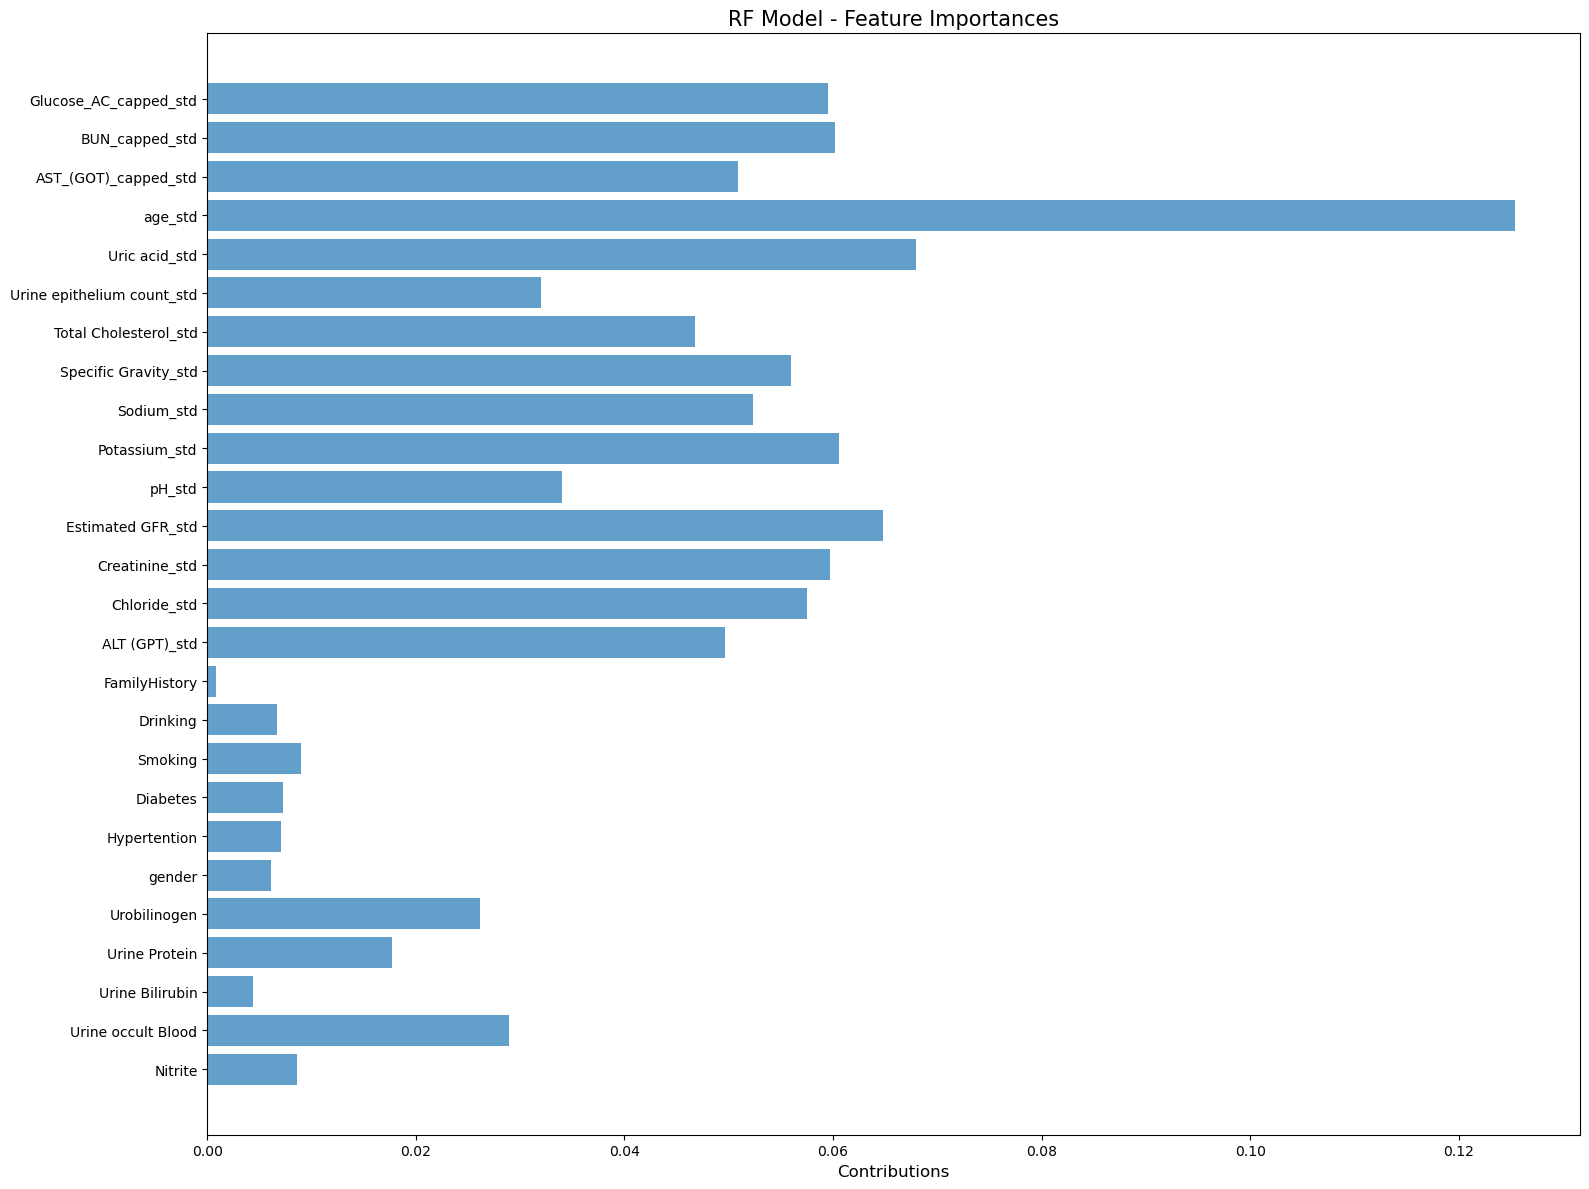

                       Feature  Importance
22                     age_std    0.125344
21               Uric acid_std    0.067915
14           Estimated GFR_std    0.064765
16               Potassium_std    0.060572
24              BUN_capped_std    0.060215
13              Creatinine_std    0.059673
25       Glucose_AC_capped_std    0.059518
12                Chloride_std    0.057494
18        Specific Gravity_std    0.055947
17                  Sodium_std    0.052350
23        AST_(GOT)_capped_std    0.050844
11               ALT (GPT)_std    0.049670
19       Total Cholesterol_std    0.046719
15                      pH_std    0.034030
20  Urine epithelium count_std    0.032036
1           Urine occult Blood    0.028941
4                 Urobilinogen    0.026191
3                Urine Protein    0.017749
8                      Smoking    0.009032
0                      Nitrite    0.008629
7                     Diabetes    0.007219
6                 Hypertention    0.007073
9          

In [110]:
# Feature importance:
feature_names = X_train_scaled.columns
importances = rf_model.feature_importances_

# Plot
y_pos = np.arange(len(feature_names))

fig, ax = plt.subplots(figsize=(16, 12))
ax.barh(y_pos, importances, align='center', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names, fontsize=10)
ax.set_xlabel('Contributions', fontsize=12)
ax.set_title('RF Model - Feature Importances', fontsize=15)

plt.tight_layout()
plt.show()
# Create DataFrame of feature importances

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the table
print(importance_df.to_string()) 

### XGBoost model

In [125]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 79.186%
Precision: 80.488%
Recall: 96.491%


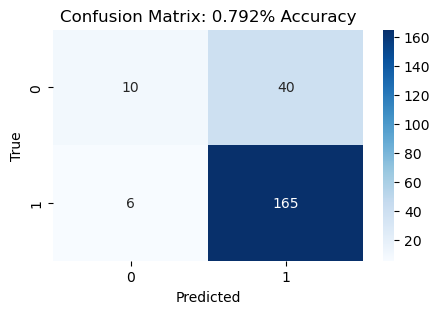

In [126]:
xgb_y_preds = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_y_preds)
xgb_precision = precision_score(y_test, xgb_y_preds ) 
xgb_recall = recall_score(y_test, xgb_y_preds )  

print(f"Accuracy: {xgb_acc * 100:.3f}%")
print(f"Precision: {xgb_precision * 100:.3f}%")
print(f"Recall: {xgb_recall * 100:.3f}%")

xgb_conf_mat = confusion_matrix(y_test, xgb_y_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(xgb_conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {xgb_acc:.3f}% Accuracy')
plt.show()

In [127]:
## Handling imbalanced data
# Compute scale_pos_weight to handle class imbalance
neg = (y_train == False).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Train the XGBoost model
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

scale_pos_weight: 0.22
              precision    recall  f1-score   support

       False      0.485     0.320     0.386        50
        True      0.819     0.901     0.858       171

    accuracy                          0.769       221
   macro avg      0.652     0.610     0.622       221
weighted avg      0.744     0.769     0.751       221



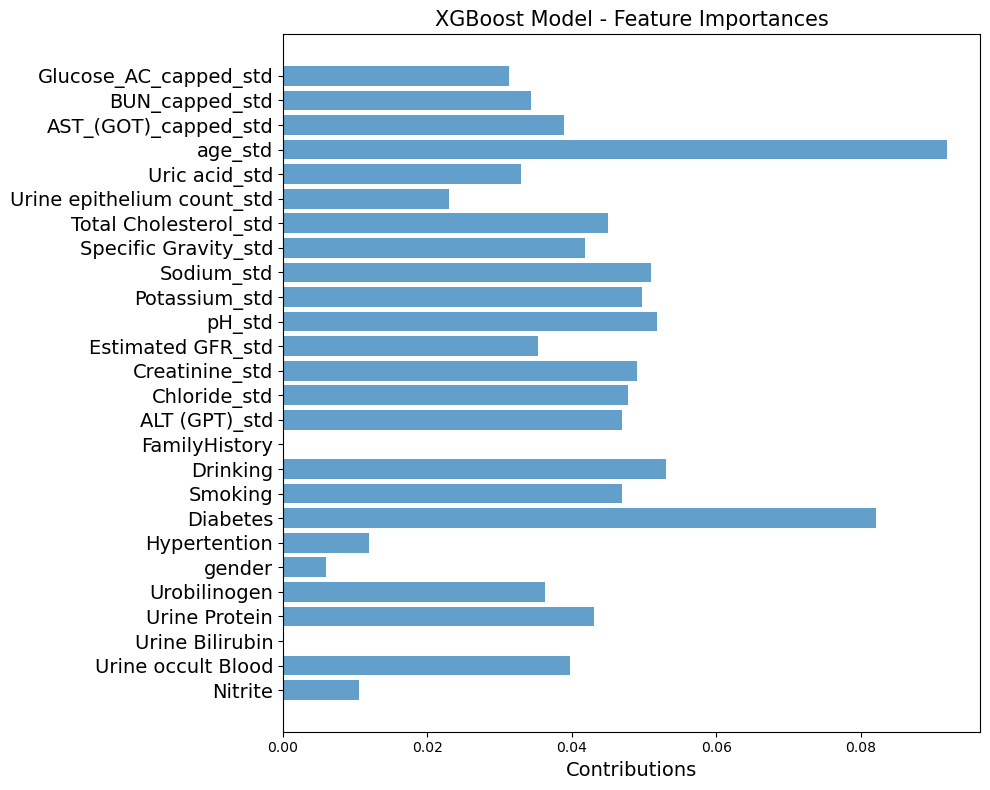

                       Feature  Importance
22                     age_std    0.091880
7                     Diabetes    0.082093
9                     Drinking    0.052976
15                      pH_std    0.051734
17                  Sodium_std    0.050895
16               Potassium_std    0.049636
13              Creatinine_std    0.049018
12                Chloride_std    0.047799
11               ALT (GPT)_std    0.046986
8                      Smoking    0.046978
19       Total Cholesterol_std    0.045052
3                Urine Protein    0.043085
18        Specific Gravity_std    0.041854
1           Urine occult Blood    0.039673
23        AST_(GOT)_capped_std    0.038859
4                 Urobilinogen    0.036264
14           Estimated GFR_std    0.035337
24              BUN_capped_std    0.034271
21               Uric acid_std    0.032963
25       Glucose_AC_capped_std    0.031338
20  Urine epithelium count_std    0.023015
6                 Hypertention    0.011852
0          

In [128]:
# Get feature names from training data
feature_names = X_train_scaled.columns  
importance = xgb_model.feature_importances_

# Plot
y_pos = np.arange(len(feature_names))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_pos, importance, align='center', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names, fontsize=14)
ax.set_xlabel('Contributions', fontsize=14)
ax.set_title('XGBoost Model - Feature Importances', fontsize=15)

plt.tight_layout()
plt.show()
# Create a DataFrame of feature importances

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Show all rows
print(xgb_importance_df.to_string())

                   Feature  Importance  Correlation  Signed_Correlation
                   age_std    0.091880     0.255503            0.255503
                  Diabetes    0.082093     0.020326            0.020326
                  Drinking    0.052976     0.040260            0.040260
                    pH_std    0.051734     0.009424            0.009424
                Sodium_std    0.050895     0.042296           -0.042296
             Potassium_std    0.049636     0.126264            0.126264
            Creatinine_std    0.049018     0.044247            0.044247
              Chloride_std    0.047799     0.046514           -0.046514
             ALT (GPT)_std    0.046986     0.028346           -0.028346
                   Smoking    0.046978     0.105321            0.105321
     Total Cholesterol_std    0.045052     0.044542           -0.044542
             Urine Protein    0.043085     0.043055            0.043055
      Specific Gravity_std    0.041854     0.083126           -0

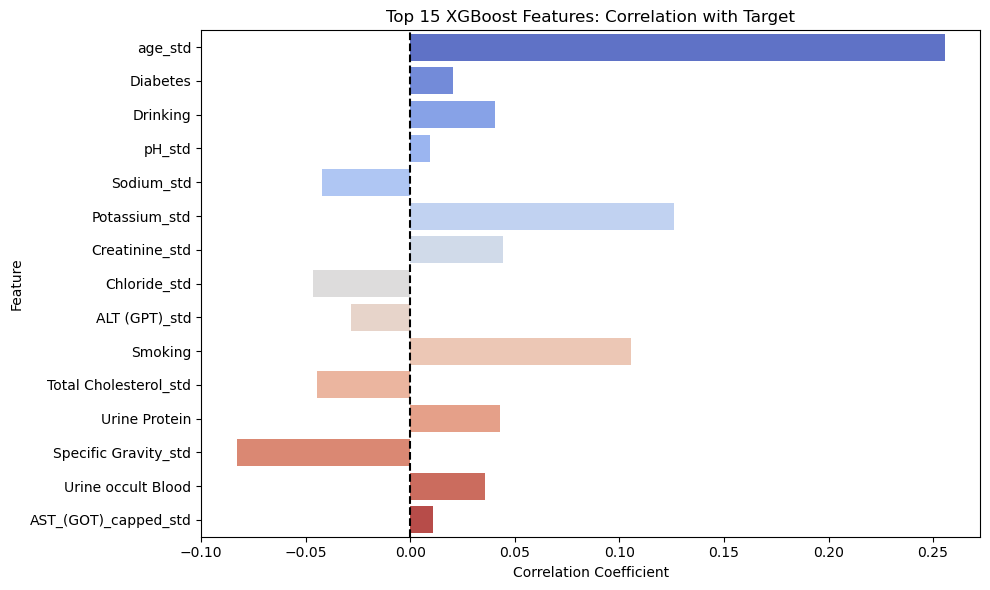

In [115]:
# Compute correlations with the target
# (Assumes dfm contains both features and 'success_any' as the binary target)

correlations = dfm[X_train_scaled.columns].corrwith(dfm['Disease'])

# Sort by absolute value of correlation
correlation_df = correlations.abs().sort_values(ascending=False).to_frame(name='Correlation')
correlation_df['Signed_Correlation'] = correlations  # add signed value

# Reset index to have 'Feature' column
correlation_df = correlation_df.reset_index().rename(columns={'index': 'Feature'})

# Merge with XGBoost importance
xgb_corr_merged = xgb_importance_df.merge(correlation_df, on='Feature', how='left')

# Sort and display
xgb_corr_merged = xgb_corr_merged.sort_values(by='Importance', ascending=False)

# Print full table
print(xgb_corr_merged.to_string(index=False))

# Optional: Plot correlation for top features
import seaborn as sns
import matplotlib.pyplot as plt

top_corr = xgb_corr_merged.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_corr, x='Signed_Correlation', y='Feature', palette='coolwarm')
plt.axvline(0, linestyle='--', color='k')
plt.title('Top 15 XGBoost Features: Correlation with Target')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [116]:
# hyperparameter tuning
# Initialize XGBoost Classifier 
xgb_model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',       
    use_label_encoder=False,     
    random_state=42
)
# Define Hyperparameter Grid for GridSearchCV 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
# Perform Grid Search ---
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,                 
    scoring='accuracy',  
    n_jobs=-1,            
    verbose=2             
)
print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Get Best Model and Parameters 
best_xgb_model = grid_search.best_estimator_

print("\n--- GridSearchCV Results ---")
print("✅ Best parameters found:", grid_search.best_params_)
print(f"✅ Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate on the test set
from sklearn.metrics import accuracy_score
y_pred = best_xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Starting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- GridSearchCV Results ---
✅ Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
✅ Best cross-validation score: 0.8327
Test Set Accuracy: 0.7919


Accuracy: 76.923%
Precision: 78.846%
Recall: 95.906%


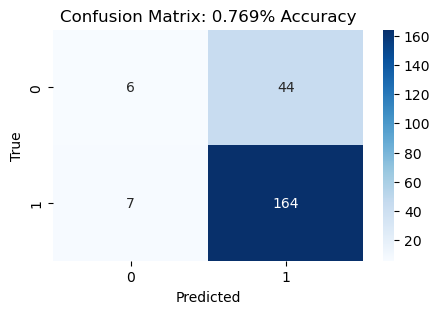

In [117]:
svc_model = SVC(C=10, gamma = 0.01, probability=True)
svc_model.fit(X_train, y_train)
svc_y_preds = svc_model.predict(X_test)

svc_acc = accuracy_score(y_test, svc_y_preds)
svc_precision = precision_score(y_test, svc_y_preds ) 
svc_recall = recall_score(y_test, svc_y_preds )  

print(f"Accuracy: {svc_acc * 100:.3f}%")
print(f"Precision: {svc_precision * 100:.3f}%")
print(f"Recall: {svc_recall * 100:.3f}%")

svc_conf_mat = confusion_matrix(y_test, svc_y_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(svc_conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {svc_acc:.3f}% Accuracy')
plt.show()

### Neural Network model

Accuracy: 72.851%
Precision: 80.328%
Recall: 85.965%


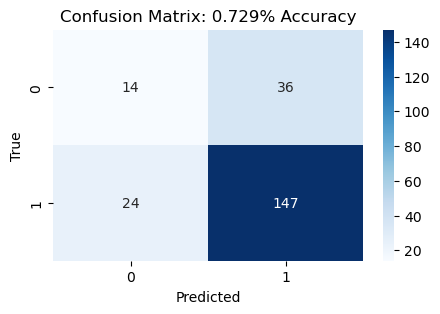

In [118]:
NN_model = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
NN_y_preds = NN_model.predict(X_test)

NN_acc = accuracy_score(y_test, NN_y_preds)
NN_precision = precision_score(y_test, NN_y_preds ) 
NN_recall = recall_score(y_test, NN_y_preds )  

print(f"Accuracy: {NN_acc * 100:.3f}%")
print(f"Precision: {NN_precision * 100:.3f}%")
print(f"Recall: {NN_recall * 100:.3f}%")

NN_conf_mat = confusion_matrix(y_test, NN_y_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(NN_conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {NN_acc:.3f}% Accuracy')
plt.show()

In [119]:
#Hyperparameter tuning:

import scikeras 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification 
from sklearn.metrics import accuracy_score, classification_report

# Import Keras/TensorFlow and Scikeras for Keras-Scikit-learn integration
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier # Use KerasRegressor for regression

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress info and warning messages

print(f"TensorFlow Version: {tf.__version__}")
print(f"Scikeras Version: {scikeras.__version__}")


# Define the Keras Model Creation Function
def create_model(num_hidden_layers=1, units=32, learning_rate=0.001, activation='relu', optimizer='Adam', dropout_rate=0.0):
    model = keras.Sequential()
    # Input layer
    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))

    # Hidden layers
    for _ in range(num_hidden_layers):
        model.add(keras.layers.Dense(units=units, activation=activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))

    # Output layer for binary classification
    model.add(keras.layers.Dense(units=1, activation='sigmoid')) # Use 'softmax' for multi-class and appropriate units

    # Compile the model
   
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.Adam(learning_rate=learning_rate) # Default to Adam

    model.compile(optimizer=opt,
                  loss='binary_crossentropy', # Use 'categorical_crossentropy' for multi-class
                  metrics=['accuracy'])
    return model

# Pass the function that creates the model
keras_clf = KerasClassifier(
    model=create_model,
    verbose=0, # Suppress Keras training output during tuning
    epochs=10, # Set a base number of epochs for each trial
    batch_size=32 # Set a base batch size
)

# Define Hyperparameter Distribution for Randomized Search 
param_dist = {
    'model__num_hidden_layers': [1, 2, 3], 
    'model__units': [16, 32, 64, 128],    
    'model__learning_rate': [0.001, 0.005, 0.01, 0.05], 
    'model__activation': ['relu', 'tanh'], 
    'model__optimizer': ['Adam', 'SGD'],   
    'model__dropout_rate': [0.0, 0.2, 0.3, 0.5], 
    'batch_size': [16, 32, 64], 
    'epochs': [20, 30, 40], 
}

# Perform Randomized Search 
print("\n--- Starting RandomizedSearchCV for Neural Network ---")
random_search_nn = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=20, 
    cv=3,      
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1,
    random_state=42
)

random_search_nn.fit(X_train_scaled, y_train)

# --- 7. Get Best Model and Parameters ---
best_nn_model = random_search_nn.best_estimator_

print("\n--- RandomizedSearchCV Neural Network Results ---")
print("✅ Best parameters found:", random_search_nn.best_params_)
print(f"✅ Best cross-validation score: {random_search_nn.best_score_:.4f}")

# Evaluate Best Model on Test Set 
y_pred_nn = best_nn_model.predict(X_test_scaled)
# For binary classification with sigmoid output, predict() typically gives probabilities.
# You need to convert them to class labels (0 or 1).
y_pred_nn_classes = (y_pred_nn > 0.5).astype(int)

test_accuracy_nn = accuracy_score(y_test, y_pred_nn_classes)
print(f"\nTest Set Accuracy (Neural Network best model): {test_accuracy_nn:.4f}")
print("Classification Report (Neural Network best model):\n", classification_report(y_test, y_pred_nn_classes))

TensorFlow Version: 2.19.0
Scikeras Version: 0.13.0

--- Starting RandomizedSearchCV for Neural Network ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- RandomizedSearchCV Neural Network Results ---
✅ Best parameters found: {'model__units': 128, 'model__optimizer': 'SGD', 'model__num_hidden_layers': 2, 'model__learning_rate': 0.05, 'model__dropout_rate': 0.0, 'model__activation': 'relu', 'epochs': 20, 'batch_size': 32}
✅ Best cross-validation score: 0.8327

Test Set Accuracy (Neural Network best model): 0.7738
Classification Report (Neural Network best model):
               precision    recall  f1-score   support

       False       0.50      0.26      0.34        50
        True       0.81      0.92      0.86       171

    accuracy                           0.77       221
   macro avg       0.66      0.59      0.60       221
weighted avg       0.74      0.77      0.75       221



In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Dictionary to collect metrics
model_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    
}

for m in models:
    model = m['model']
    label = m['label']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get probability or decision function for AUC/ROC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())  # Normalize
    else:
        print(f"⚠️ Model {label} has no probability or decision function. Skipping.")
        continue

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)

    model_metrics['Model'].append(label)
    model_metrics['Accuracy'].append(acc)
    model_metrics['Precision'].append(prec)
    model_metrics['Recall'].append(rec)
   


In [122]:
# Create summary table
metrics_df = pd.DataFrame(model_metrics)

# Print the summary table with rounded values for readability
print("\n📋 Model Evaluation Summary Table:")
print(metrics_df.round(2))


📋 Model Evaluation Summary Table:
     Model  Accuracy  Precision  Recall
0       DT      0.77       0.79    0.95
1      SVM      0.77       0.79    0.96
2  XGBoost      0.79       0.80    0.97
3       RF      0.79       0.80    0.98
4       NN      0.80       0.81    0.96


## Creation of a biomarker panel
The panel combines established risk factors (age, smoking, hematuria) with renal and metabolic markers (GFR, creatinine, potassium, urine protein) to ensure predictive strength and clinical feasibility.

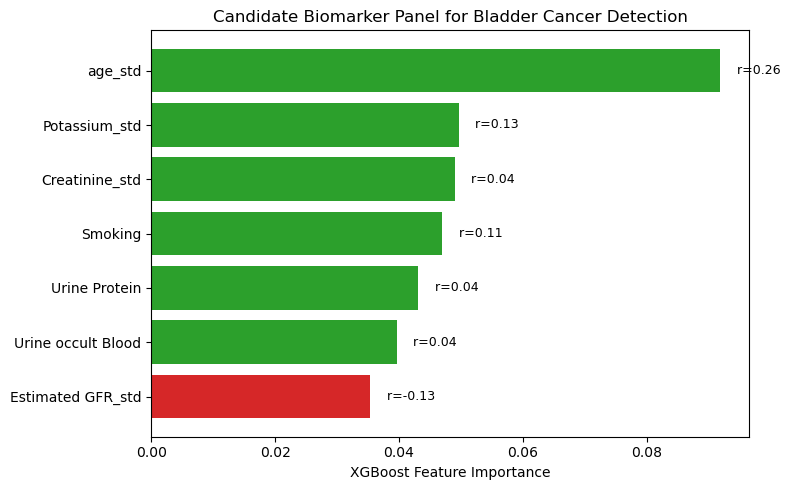

In [123]:
data = {
    "Feature": [
        "age_std", "Diabetes", "Drinking", "pH_std", "Sodium_std", "Potassium_std",
        "Creatinine_std", "Chloride_std", "ALT (GPT)_std", "Smoking", "Total Cholesterol_std",
        "Urine Protein", "Specific Gravity_std", "Urine occult Blood", "AST_(GOT)_capped_std",
        "Urobilinogen", "Estimated GFR_std", "BUN_capped_std", "Uric acid_std",
        "Glucose_AC_capped_std", "Urine epithelium count_std", "Hypertention", "Nitrite",
        "gender", "FamilyHistory", "Urine Bilirubin"
    ],
    "Importance": [
        0.091880, 0.082093, 0.052976, 0.051734, 0.050895, 0.049636, 0.049018, 0.047799, 
        0.046986, 0.046978, 0.045052, 0.043085, 0.041854, 0.039673, 0.038859, 0.036264, 
        0.035337, 0.034271, 0.032963, 0.031338, 0.023015, 0.011852, 0.010534, 0.005907, 
        0.000000, 0.000000
    ],
    "Signed_Correlation": [
        0.255503, 0.020326, 0.040260, 0.009424, -0.042296, 0.126264, 0.044247, -0.046514,
        -0.028346, 0.105321, -0.044542, 0.043055, -0.083126, 0.035862, 0.010789, -0.031171,
        -0.129079, 0.062627, 0.073336, 0.008230, -0.009412, 0.049956, 0.052184, 0.039164,
        0.040230, 0.028235
    ]
}

df = pd.DataFrame(data)

# Select biomarker panel (based on importance + correlation + plausibility) ---
panel_features = [
    "age_std", "Smoking", "Potassium_std", "Estimated GFR_std",
    "Creatinine_std", "Urine Protein", "Urine occult Blood"
]
df_panel = df[df["Feature"].isin(panel_features)].copy()
df_panel = df_panel.sort_values("Importance", ascending=True)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.barh(
    df_panel["Feature"], df_panel["Importance"],
    color=["#2ca02c" if x > 0 else "#d62728" for x in df_panel["Signed_Correlation"]]
)
plt.xlabel("XGBoost Feature Importance")
plt.title("Candidate Biomarker Panel for Bladder Cancer Detection")

# Add correlation labels to bars
for i, (imp, corr) in enumerate(zip(df_panel["Importance"], df_panel["Signed_Correlation"])):
    plt.text(imp + 0.002, i, f" r={corr:.2f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()
